# AWS AutoPilot Model Training on Subset 2
### Supporting: *Leveraging AutoML for Advanced Network Traffic Analysis and Intrusion Detection by Enhancing Security with a Multi-Feature IDS Dataset*

**Author:** Chibuike S Abana, Doctoral Candidate, George Washington University  
**Date:** March 22, 2025  

**Purpose:**  
This notebook documents the training of machine learning models using Amazon SageMaker AutoPilot on Subset 2 of the enhanced IDS dataset. AutoPilot automates feature engineering, model selection, and hyperparameter tuning to identify the most effective models for network intrusion detection. The results contribute to the overall evaluation of AutoML frameworks within this research.

**License:** MIT License  
This code and methodology are released under the MIT License. Use, modification, and distribution are permitted with attribution. See the `LICENSE` file for full terms.

In [1]:
# to get the latest sagemaker python sdk
!pip install -U sagemaker

# Importing libraries

In [ ]:
# importing all libraries needed for workflow
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sagemaker
from sagemaker import *
from sagemaker import AutoML
from sagemaker import get_execution_role
from sagemaker.automl.automlv2 import *
from time import gmtime, strftime, sleep
from pprint import pprint
import json
import io
from urllib.parse import urlparse
from sklearn.metrics import *
import matplotlib.pyplot as plt
import boto3
from botocore.exceptions import ClientError

# Setting up envirnonment 

In [3]:
# setting up the environment
logging.getLogger("botocore.httpchecksum").setLevel(logging.WARNING)

print("setting up session")
# setting up sagemaker envirnonment
region = boto3.Session().region_name
session = sagemaker.Session()

print("setting up paths to datasets")
# S3 bucket configuration
bucket = "final-praxis"
prefix = "Dataset/output-path/new-processed-data"

# Define S3 paths
train_data_s3_path = f"s3://{bucket}/{prefix}/training_subset2.csv"
test_data_s3_path = f"s3://{bucket}/{prefix}/testing.csv"
test_data_no_label_s3_path = f"s3://{bucket}/{prefix}/testing_no_label.csv"
test_data_nolabel_header_s3_path = f"s3://{bucket}/{prefix}/testing_no_label_header.csv"
validation_data_s3_path = f"s3://{bucket}/{prefix}/validation.csv"

# Initialize S3 client
s3_client = boto3.client('s3')
print("Loading dataset into dataframe...")
try:
    # Load datasets with error handling
    print("Loading training data...")
    training_data = pd.read_csv(train_data_s3_path, header=0)
    print(f"Training data shape: {training_data.shape}")
    
    print("\nLoading testing data...")
    testing_data = pd.read_csv(test_data_s3_path, header=0)
    print(f"Testing data shape: {testing_data.shape}")
    
    print("\nLoading testing data without labels...")
    testing_no_label_data = pd.read_csv(test_data_no_label_s3_path, header=0)
    print(f"Testing data (no labels) shape: {testing_no_label_data.shape}")

    print("\nLoading testing data without labels and header...")
    testing_no_label_header_data = pd.read_csv(test_data_nolabel_header_s3_path, header=None)
    print(f"Testing data (no labels and header) shape: {testing_no_label_header_data.shape}")

    print("\nLoading validation data...")
    validation_data = pd.read_csv(validation_data_s3_path, header=0)
    print(f"validation data shape: {validation_data.shape}")

    # Basic data validation
    if training_data.empty or testing_data.empty or testing_no_label_data.empty or testing_no_label_header_data.empty or validation_data.empty:
        print("Warning: One or more datasets are empty!")
        
except ClientError as e:
    print(f"Error accessing S3: {e}")
except pd.errors.EmptyDataError:
    print("Error: One of the CSV files is empty")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print("Setting model training output on s3")
automl_output_s3_path = "s3://final-praxis/automl-output/final-project/"

print(f"training output path: {automl_output_s3_path}")

# session and role
role = sagemaker.get_execution_role()

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

print("setting instance type for tranformer")
# Deployment instance type
my_instance_type = "ml.m5.2xlarge"
print(f"Instance type for transformer is: {my_instance_type}")

setting up session
setting up paths to datasets
Loading dataset into dataframe...
Loading training data...
Training data shape: (2210607, 80)

Loading testing data...
Testing data shape: (5415919, 80)

Loading testing data without labels...
Testing data (no labels) shape: (5415919, 79)

Loading testing data without labels and header...
Testing data (no labels and header) shape: (5415919, 79)

Loading validation data...
validation data shape: (3610612, 80)
Setting model training output on s3
training output path: s3://final-praxis/automl-output/final-project/
setting instance type for tranformer
Instance type for transformer is: ml.m5.2xlarge


# Previewing Dataset

In [4]:
# Preview the data
print("Training Data Shape:", training_data.shape)
print("\nSummary of Label column: \n", training_data['Label'].value_counts())
print("\nTraining Data Head:")
training_data.head()

Training Data Shape: (2210607, 80)

Summary of Label column: 
 Label
Benign                      750000
DoS Hulk                    721264
DDoS-HOIC                   432917
DDoS-LOIC-HTTP              115731
Botnet Ares                  57169
SSH-BruteForce               37679
DoS GoldenEye                25000
DDoS-LOIC-UDP                25000
DoS Slowloris                24994
Web Attack - XSS             10447
Web Attack - Brute Force     10406
Name: count, dtype: int64

Training Data Head:


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Total TCP Flow Time,Label
0,6,4838,5,5,310,935,310,0,62.00,138.636215,...,0.0,0.0,0,0,0.0,0.0,0,0,4838,DDoS-HOIC
1,6,117880,5,5,302,935,302,0,60.40,135.058506,...,0.0,0.0,0,0,0.0,0.0,0,0,117880,DoS Hulk
2,6,959813,8,5,1164,935,291,0,145.50,155.546043,...,0.0,0.0,0,0,0.0,0.0,0,0,959813,DoS Hulk
3,6,152344,5,5,354,935,354,0,70.80,158.313613,...,0.0,0.0,0,0,0.0,0.0,0,0,152344,DoS Hulk
4,6,11674,4,1,77,0,46,0,19.25,23.056091,...,0.0,0.0,0,0,0.0,0.0,0,0,172114889,Benign


In [5]:
print("\nTesting Data Shape:", testing_data.shape)
print("\nSummary of Label column: \n", testing_data['Label'].value_counts())
print("\nTesting Data Head:")
testing_data.head()


Testing Data Shape: (5415919, 80)

Summary of Label column: 
 Label
Benign                      5002433
DoS Hulk                     216379
DDoS-HOIC                    129875
DDoS-LOIC-HTTP                34720
Botnet Ares                   17150
SSH-BruteForce                11303
DoS GoldenEye                  2707
DoS Slowloris                  1019
DDoS-LOIC-UDP                   303
Web Attack - Brute Force         16
Web Attack - XSS                 14
Name: count, dtype: int64

Testing Data Head:


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Total TCP Flow Time,Label
0,17,11284,1,1,33,94,33,33,33.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,0,Benign
1,6,24209,4,2,77,31,46,0,19.250000,23.056091,...,0.0,0.0,0,0,0.0,0.0,0,0,170385666,Benign
2,6,218096,3,3,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,218096,Benign
3,6,1033,5,5,161,488,161,0,32.200000,72.001389,...,0.0,0.0,0,0,0.0,0.0,0,0,1033,Benign
4,6,4238522,11,7,1148,1581,677,0,104.363636,202.294475,...,0.0,0.0,0,0,0.0,0.0,0,0,4238522,Benign


In [6]:
print("\nTesting Data Shape:", testing_no_label_data.shape)
print("\nTesting Data Head:")
testing_no_label_data.head()


Testing Data Shape: (5415919, 79)

Testing Data Head:


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Total TCP Flow Time
0,17,11284,1,1,33,94,33,33,33.000000,0.000000,...,8,0.0,0.0,0,0,0.0,0.0,0,0,0
1,6,24209,4,2,77,31,46,0,19.250000,23.056091,...,20,0.0,0.0,0,0,0.0,0.0,0,0,170385666
2,6,218096,3,3,0,0,0,0,0.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,218096
3,6,1033,5,5,161,488,161,0,32.200000,72.001389,...,20,0.0,0.0,0,0,0.0,0.0,0,0,1033
4,6,4238522,11,7,1148,1581,677,0,104.363636,202.294475,...,20,0.0,0.0,0,0,0.0,0.0,0,0,4238522


In [7]:
print("\nTesting Data Shape:", testing_no_label_header_data.shape)
print("\nTesting Data Head:")
testing_no_label_header_data.head()


Testing Data Shape: (5415919, 79)

Testing Data Head:


,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,17,11284,1,1,33,94,33,33,33.000000,0.000000,...,8,0.0,0.0,0,0,0.0,0.0,0,0,0
1,6,24209,4,2,77,31,46,0,19.250000,23.056091,...,20,0.0,0.0,0,0,0.0,0.0,0,0,170385666
2,6,218096,3,3,0,0,0,0,0.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,218096
3,6,1033,5,5,161,488,161,0,32.200000,72.001389,...,20,0.0,0.0,0,0,0.0,0.0,0,0,1033
4,6,4238522,11,7,1148,1581,677,0,104.363636,202.294475,...,20,0.0,0.0,0,0,0.0,0.0,0,0,4238522


In [8]:
print("\nValidation Data Shape:", validation_data.shape)
print("\nSummary of Label column: \n", validation_data['Label'].value_counts())
print("\nValidation Data Head:")
validation_data.head()


Validation Data Shape: (3610612, 80)

Summary of Label column: 
 Label
Benign                      3334954
DoS Hulk                     144253
DDoS-HOIC                     86584
DDoS-LOIC-HTTP                23146
Botnet Ares                   11434
SSH-BruteForce                 7536
DoS GoldenEye                  1805
DoS Slowloris                   679
DDoS-LOIC-UDP                   202
Web Attack - Brute Force         10
Web Attack - XSS                  9
Name: count, dtype: int64

Validation Data Head:


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Total TCP Flow Time,Label
0,6,117060497,35,29,2552,6419,405,0,72.914286,83.162977,...,374939.000000,420152.949886,672032,77846,5.811635e+07,232072.445585,58280453,57952253,117060497,Benign
1,6,117268395,16,18,1005,5592,362,0,62.812500,101.487746,...,327000.000000,241901.229844,498050,155950,5.822920e+07,370398.088335,58491106,57967284,117268395,Benign
2,6,61394552,15,14,667,3391,333,0,44.466667,99.398093,...,211008.666667,346886.613892,919088,69357,1.000984e+07,37887.430890,10031069,9936831,61394552,Benign
3,6,5117283,9,8,1308,2364,436,0,145.333333,218.000000,...,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,5117283,Benign
4,6,1700526,8,7,1144,1581,677,0,143.000000,227.969923,...,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,1700526,Benign


# Setting up the SageMaker Autopilot Job

In [9]:
# Setting up automl job config

# the objective with BalancedAccuracy

automl_job_objective = {
    'MetricName': 'BalancedAccuracy'
}


base_job_name="subset-2-autopilot-praxis"

target_attribute_name="Label"

train_input = AutoMLInput(
    target_attribute_name=target_attribute_name,
    channel_type="training",
    content_type="text/csv;header=present",
    inputs=train_data_s3_path
)

validation_input = AutoMLInput(
    target_attribute_name=target_attribute_name,
    channel_type="validation",
    content_type="text/csv;header=present",
    inputs=validation_data_s3_path
)

automl = AutoML(
    role=role,
    target_attribute_name=target_attribute_name,
    base_job_name=base_job_name,
    sagemaker_session=session,
    output_path=automl_output_s3_path,
    problem_type="MulticlassClassification",
    total_job_runtime_in_seconds=18000,
    max_candidates=30,
    job_objective=automl_job_objective
)

# Calling the automl using fit on SageMaker Autopilot Job

In [10]:
# calling fit on the train_file csv with automl

print("Starting AutoML job with fit()...")
automl.fit(inputs=[train_input, validation_input], job_name=base_job_name, wait=False, logs=False)

Starting AutoML job with fit()...


[03/23/25 05:01:12] INFO     Creating auto-ml-job with name: subset-2-autopilot-praxis              ]8;id=996403;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=359690;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#2604\2604]8;;\

# Tracking the Status

In [11]:
print("JobStatus - Secondary Status")
print("------------------------------")

describe_response = automl.describe_auto_ml_job()
print(describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"])
job_run_status = describe_response["AutoMLJobStatus"]

while job_run_status not in ("Failed", "Completed", "Stopped"):
    describe_response = automl.describe_auto_ml_job()
    job_run_status = describe_response["AutoMLJobStatus"]

    print(
        describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"]
    )
    sleep(30)

JobStatus - Secondary Status
------------------------------
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - Analyzing

# Previewing SageMaker Autopilot Job Results / metrics

In [12]:
# Shows the best candidate based on our primary metrics  "Accuracy"
thebest_candidate = automl.describe_auto_ml_job()["BestCandidate"]
best_candidate_name = thebest_candidate["CandidateName"]
pprint(thebest_candidate)
print("\n")
print("CandidateName: " + best_candidate_name)
print(
    "FinalAutoMLJobObjectiveMetricName: "
    + thebest_candidate["FinalAutoMLJobObjectiveMetric"]["MetricName"]
)
print(
    "FinalAutoMLJobObjectiveMetricValue: "
    + str(thebest_candidate["FinalAutoMLJobObjectiveMetric"]["Value"])
)

{'CandidateName': 'subset-2-autopilot-praxis07PLeah-011-74d08cd5',
 'CandidateProperties': {'CandidateMetrics': [{'MetricName': 'F1macro',
                                               'Set': 'Validation',
                                               'StandardMetricName': 'F1macro',
                                               'Value': 0.9783999919891357},
                                              {'MetricName': 'PrecisionMacro',
                                               'Set': 'Validation',
                                               'StandardMetricName': 'PrecisionMacro',
                                               'Value': 0.9646599888801575},
                                              {'MetricName': 'Accuracy',
                                               'Set': 'Validation',
                                               'StandardMetricName': 'Accuracy',
                                               'Value': 0.9999899864196777},
                          

In [13]:
# Listing all the models candidates
automl.list_candidates(sort_order="Descending")

[{'CandidateName': 'subset-2-autopilot-praxis07PLeah-024-a73476e4',
  'ObjectiveStatus': 'Failed',
  'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::ProcessingJob',
    'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:324681463530:processing-job/subset-2-autopilot-praxis-db-1-df779792968b41e99fe7f9e8417f32f4',
    'CandidateStepName': 'subset-2-autopilot-praxis-db-1-df779792968b41e99fe7f9e8417f32f4'},
   {'CandidateStepType': 'AWS::SageMaker::TrainingJob',
    'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:324681463530:training-job/subset-2-autopilot-praxis-dpp6-1-aa087d716abe429ba3f3769afdefb6',
    'CandidateStepName': 'subset-2-autopilot-praxis-dpp6-1-aa087d716abe429ba3f3769afdefb6'},
   {'CandidateStepType': 'AWS::SageMaker::TransformJob',
    'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:324681463530:transform-job/subset-2-autopilot-praxis-dpp6-rpb-1-b5ef1b0d8b4d43f39f6d70b0d0',
    'CandidateStepName': 'subset-2-autopilot-praxis-dpp6-rpb-1-b5ef1b0d8b4d43f39f6d70b0d

# Checking Top 10 Candidates

In [14]:
# Number of Autopilot candidates to evaluate and run batch transform jobs.
TOP_N_CANDIDATES = 5

In [15]:
candidates = automl.list_candidates(sort_by="FinalObjectiveMetricValue", sort_order="Descending", max_results= TOP_N_CANDIDATES)
for candidate in candidates:
    print("Candidate name: ", candidate["CandidateName"])
    print("Objective metric name: ", candidate["FinalAutoMLJobObjectiveMetric"]["MetricName"])
    print("Objective metric value: ", candidate["FinalAutoMLJobObjectiveMetric"]["Value"])
    print("\n")

Candidate name:  subset-2-autopilot-praxis07PLeah-020-a30699bd
Objective metric name:  validation:balanced_accuracy
Objective metric value:  1.0


Candidate name:  subset-2-autopilot-praxis07PLeah-011-74d08cd5
Objective metric name:  validation:balanced_accuracy
Objective metric value:  1.0


Candidate name:  subset-2-autopilot-praxis07PLeah-018-3e744cbc
Objective metric name:  validation:balanced_accuracy
Objective metric value:  1.0


Candidate name:  subset-2-autopilot-praxis07PLeah-019-dac418a7
Objective metric name:  validation:balanced_accuracy
Objective metric value:  1.0


Candidate name:  subset-2-autopilot-praxis07PLeah-022-ce730212
Objective metric name:  validation:multiclass_balanced_accuracy
Objective metric value:  0.9999985098838806




# Evaluating the Best Candidate

## Creating the Models and Tranform Estimators

In [16]:
# Set up the inference response keys:
inference_response_keys = ["predicted_label",'probabilities', 'labels']
print("Inference Response Keys:", inference_response_keys)

Inference Response Keys: ['predicted_label', 'probabilities', 'labels']


In [17]:
s3_transform_output_path = "s3://final-praxis/automl-output/final-project/inference-results/output/subset-2/"

model_name=best_candidate_name
model = automl.create_model(
    name=model_name,
    candidate=thebest_candidate,
    inference_response_keys=inference_response_keys,
)

output_path = s3_transform_output_path + model_name + "/"

print(f"inference output is saved at path: {output_path}")


transformer=model.transformer(
    instance_count=1,
    instance_type=my_instance_type,
    assemble_with="Line",
    output_path=output_path,
)

print("Setting up the Batch Transform Jobs for the the best candidate")

inference output is saved at path: s3://final-praxis/automl-output/final-project/inference-results/output/subset-2/subset-2-autopilot-praxis07PLeah-011-74d08cd5/


[03/23/25 10:39:31] INFO     Creating model with name:                                              ]8;id=249068;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=92784;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\
                             subset-2-autopilot-praxis07PLeah-011-74d08cd5                                         

Setting up the Batch Transform Jobs for the the best candidate


# Starting the Transform Jobs

In [18]:
# Parsing inferencing data and starting the transformer job. using testing data with no headers and label
input_data_transform = test_data_nolabel_header_s3_path

transformer.transform(
    data=input_data_transform,
    split_type="Line",
    content_type="text/csv",
    wait=False
)
print("Starting transform job {}".format(transformer._current_job_name))

[03/23/25 10:39:44] INFO     Creating transform job with name:                                      ]8;id=903926;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=280714;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#3951\3951]8;;\
                             subset-2-autopilot-praxis07PLeah-011-74-2025-03-23-10-39-44-033                       

Starting transform job subset-2-autopilot-praxis07PLeah-011-74-2025-03-23-10-39-44-033


In [19]:
# monitoring transform jobs status
pending_complete = True
current_jobname= transformer._current_job_name
while pending_complete:
    pending_complete = False
    
    desc = sm.describe_transform_job(TransformJobName=current_jobname)
    if desc["TransformJobStatus"] not in ["Failed", "Completed"]:
        pending_complete = True
        
    print("{} transform job is running.".format(current_jobname))
    sleep(30)

desc = sm.describe_transform_job(TransformJobName=current_jobname)
print("Transform job '{}' finished with status {}".format(current_jobname, desc["TransformJobStatus"]))

print("\nTranforming job completed.")

subset-2-autopilot-praxis07PLeah-011-74-2025-03-23-10-39-44-033 transform job is running.
subset-2-autopilot-praxis07PLeah-011-74-2025-03-23-10-39-44-033 transform job is running.
subset-2-autopilot-praxis07PLeah-011-74-2025-03-23-10-39-44-033 transform job is running.
subset-2-autopilot-praxis07PLeah-011-74-2025-03-23-10-39-44-033 transform job is running.
subset-2-autopilot-praxis07PLeah-011-74-2025-03-23-10-39-44-033 transform job is running.
subset-2-autopilot-praxis07PLeah-011-74-2025-03-23-10-39-44-033 transform job is running.
subset-2-autopilot-praxis07PLeah-011-74-2025-03-23-10-39-44-033 transform job is running.
subset-2-autopilot-praxis07PLeah-011-74-2025-03-23-10-39-44-033 transform job is running.
subset-2-autopilot-praxis07PLeah-011-74-2025-03-23-10-39-44-033 transform job is running.
subset-2-autopilot-praxis07PLeah-011-74-2025-03-23-10-39-44-033 transform job is running.
subset-2-autopilot-praxis07PLeah-011-74-2025-03-23-10-39-44-033 transform job is running.
subset-2-a

# Evaluating the Inference Results

### Analysing Predictions using Sklearn

In [20]:
# Fetching the Inference output from s3

def get_csv_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:].strip("/")
    s3 = boto3.resource("s3")
    obj = s3.Object(bucket_name, "{}/{}".format(prefix, file_name))
    return obj.get()["Body"].read().decode("utf-8")

# Fetch inference outputs and build a dictionary keyed by candidate name.
test_file_out = 'testing_no_label_header.csv.out'

print("Processing inference output for the best candidate.")

pred_csv = get_csv_from_s3(transformer.output_path, test_file_out)
                           
myprediction_df = pd.read_csv(io.StringIO(pred_csv), header=None)
                           
# column names
myprediction_df.columns = ["predicted_label", "probabilities", "labels"]

# predictions
myprediction_df.head(50)

Processing inference output for the best candidate.


,predicted_label,probabilities,labels
0,Benign,"[1.0, 1.1756497468248805e-12, 3.23592118812304...","['Benign', 'Botnet Ares', 'DDoS-HOIC', 'DDoS-L..."
1,Benign,"[1.0, 4.109326594281537e-12, 3.432133321035896...","['Benign', 'Botnet Ares', 'DDoS-HOIC', 'DDoS-L..."
2,Benign,"[1.0, 8.032035323304876e-13, 7.847125726989645...","['Benign', 'Botnet Ares', 'DDoS-HOIC', 'DDoS-L..."
3,Benign,"[1.0, 9.287419444614642e-11, 3.823935265656608...","['Benign', 'Botnet Ares', 'DDoS-HOIC', 'DDoS-L..."
4,Benign,"[1.0, 1.1176545799962412e-12, 1.09192451087924...","['Benign', 'Botnet Ares', 'DDoS-HOIC', 'DDoS-L..."
5,Benign,"[1.0, 4.562814427504225e-13, 4.457771500022966...","['Benign', 'Botnet Ares', 'DDoS-HOIC', 'DDoS-L..."
6,Benign,"[1.0, 4.974775591470859e-10, 3.025693307012744...","['Benign', 'Botnet Ares', 'DDoS-HOIC', 'DDoS-L..."
7,Benign,"[1.0, 3.3534355847741892e-12, 1.84201568928510...","['Benign', 'Botnet Ares', 'DDoS-HOIC', 'DDoS-L..."
8,Benign,"[1.0, 1.1176545799962412e-12, 1.09192451087924...","['Benign', 'Botnet Ares', 'DDoS-HOIC', 'DDoS-L..."
9,Benign,"[1.0, 7.575581329778702e-13, 9.423108994488505...","['Benign', 'Botnet Ares', 'DDoS-HOIC', 'DDoS-L..."


# Visualizing and Analyzing Model Metrics on Test Data 

In [21]:
myprediction_df.shape

(5415919, 3)

In [22]:
testing_data.shape

(5415919, 80)

In [3]:
# Importing libraries for metrics analysis and evaluation
from sklearn.metrics import *
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    balanced_accuracy_score
)

from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import ast


In [24]:
# Importing libraries for metrics analysis and evaluation
from sklearn.metrics import *
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    balanced_accuracy_score
)

from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import ast


In [25]:
myprediction_df.to_csv(f"s3://final-praxis/automl-output/final-project/inference-results/output/subset-2/processed_prediction.csv", index=False)

In [25]:
load_myprediction_df =pd.read_csv("s3://final-praxis/automl-output/final-project/inference-results/output/subset-2/processed_prediction.csv", header=0)

In [26]:
# Helper function for lift curve
def compute_lift_curve(y_true_binary, probs_matrix, num_bins=10):
    """
    Given binary true labels and predicted probabilities, compute lift per decile.
    Returns a DataFrame with average lift for each bin.
    """
    data = pd.DataFrame({"y_true": y_true_binary, "probs_matrix": probs_matrix})
    data.sort_values(by="probs_matrix", ascending=False, inplace=True)
    overall_rate = data["y_true"].sum() / len(data)
    # Bin the data into quantiles
    data["bin"] = pd.qcut(data["probs_matrix"], q=num_bins, duplicates="drop")
    grouped = data.groupby("bin")
    lift_df = grouped.apply(lambda df: (df["y_true"].mean() / overall_rate)).reset_index(name="lift")
    return lift_df


=== Evaluating candidate: subset-2-autopilot-praxis07PLeah-011-74d08cd5 ===
Candidate subset-2-autopilot-praxis07PLeah-011-74d08cd5 metrics:

Balanced Accuracy report

Model Balanced Accuracy: 0.9999103

Accuracy report

Model Accuracy: 0.9999954

 Confusion Metrics


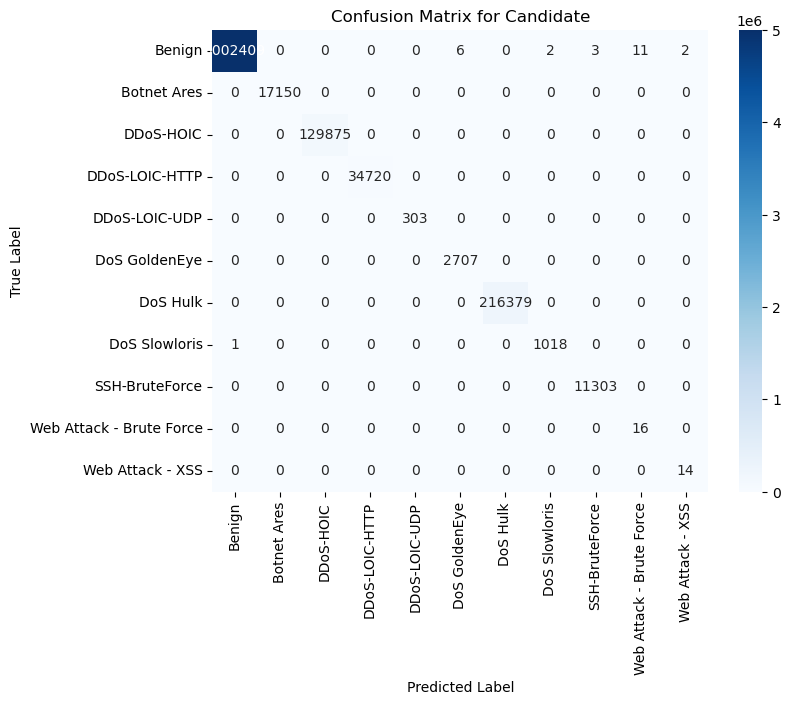


Classification Report for Candidate:
                          precision    recall  f1-score   support

                  Benign       1.00      1.00      1.00   5002433
             Botnet Ares       1.00      1.00      1.00     17150
               DDoS-HOIC       1.00      1.00      1.00    129875
          DDoS-LOIC-HTTP       1.00      1.00      1.00     34720
           DDoS-LOIC-UDP       1.00      1.00      1.00       303
           DoS GoldenEye       1.00      1.00      1.00      2707
                DoS Hulk       1.00      1.00      1.00    216379
           DoS Slowloris       1.00      1.00      1.00      1019
          SSH-BruteForce       1.00      1.00      1.00     11303
Web Attack - Brute Force       0.59      1.00      0.74        16
        Web Attack - XSS       0.88      1.00      0.93        14

                accuracy                           1.00   5415919
               macro avg       0.95      1.00      0.97   5415919
            weighted avg       1.00 

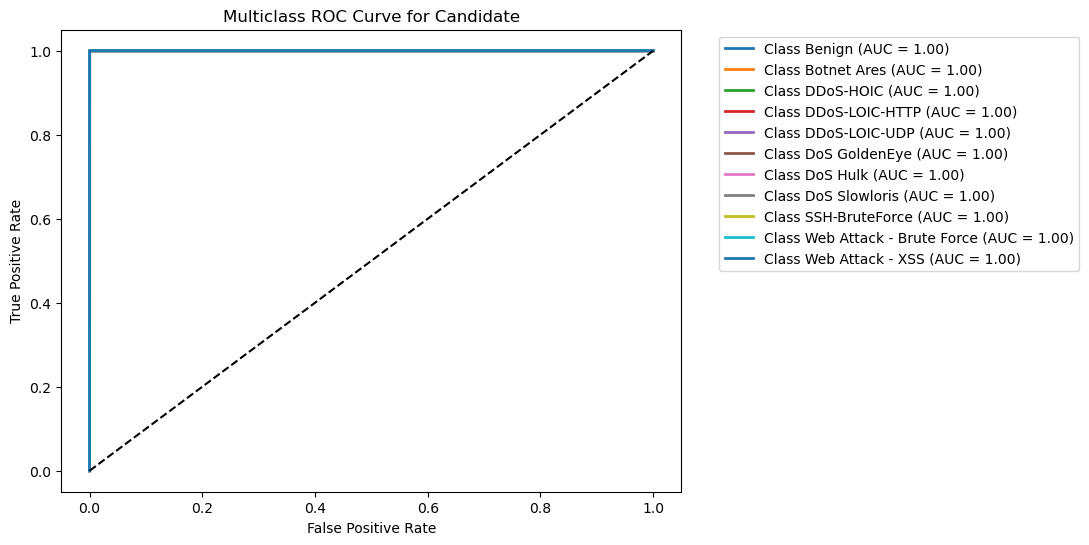


 Precision-recall Curve


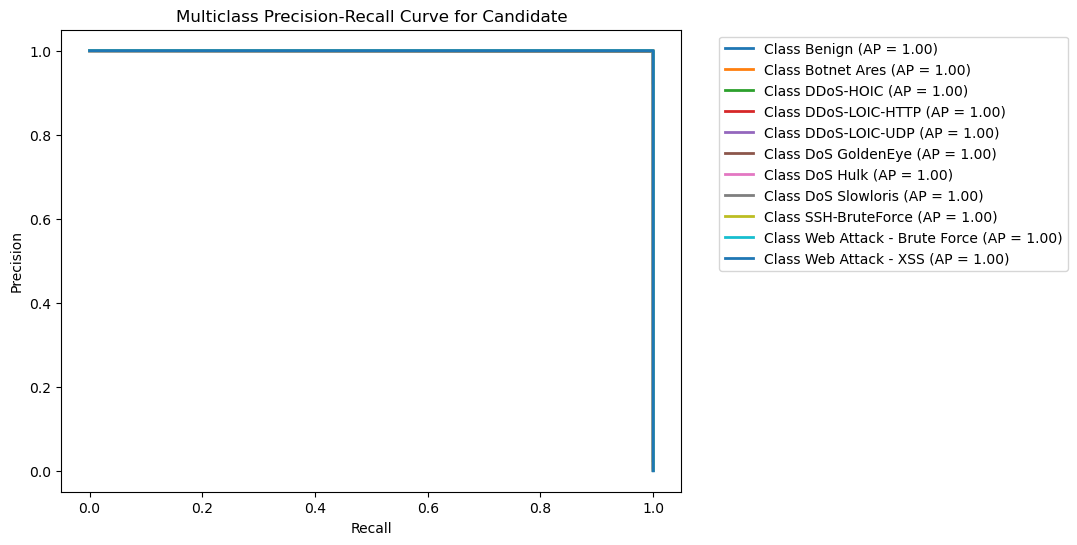


 Calibration Curves


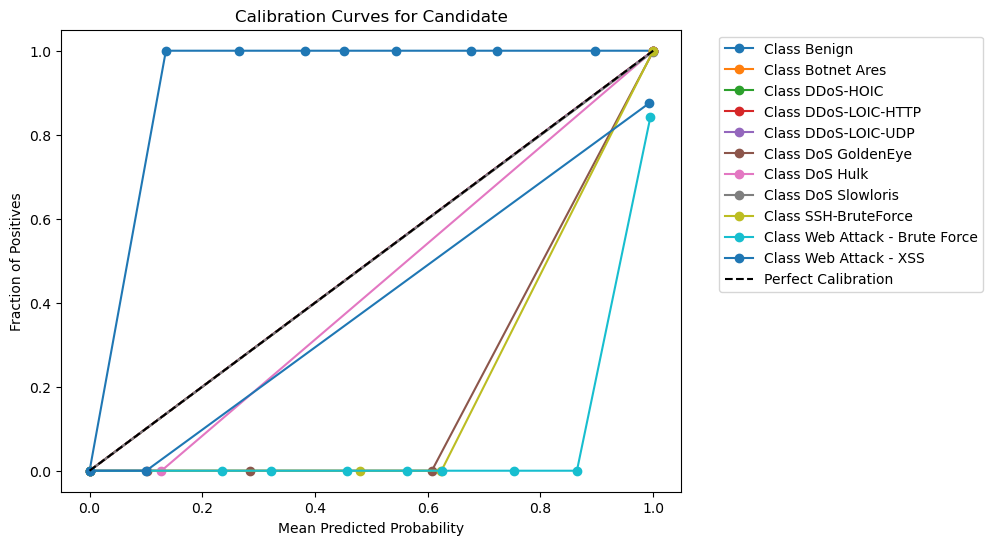


 Lift Curves


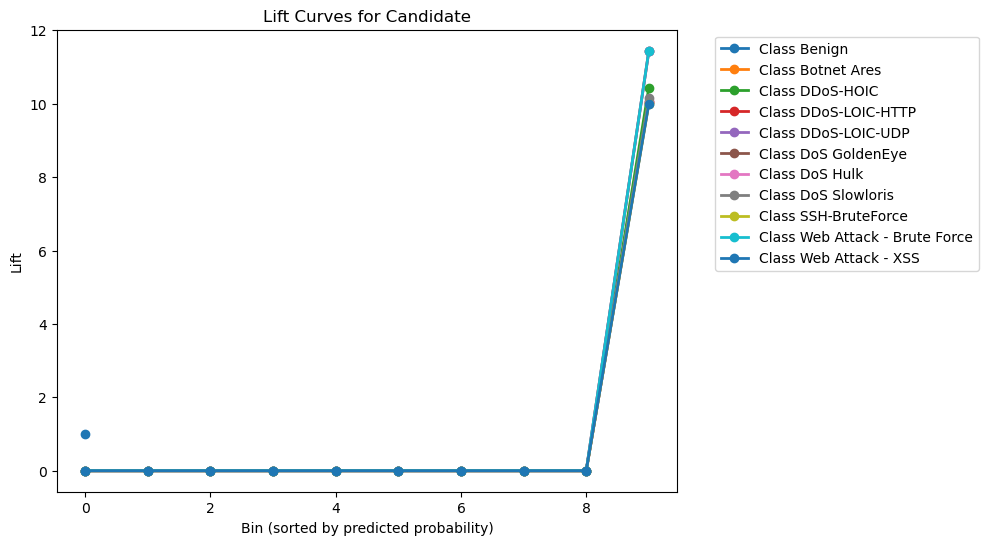


 Confidence Distribution


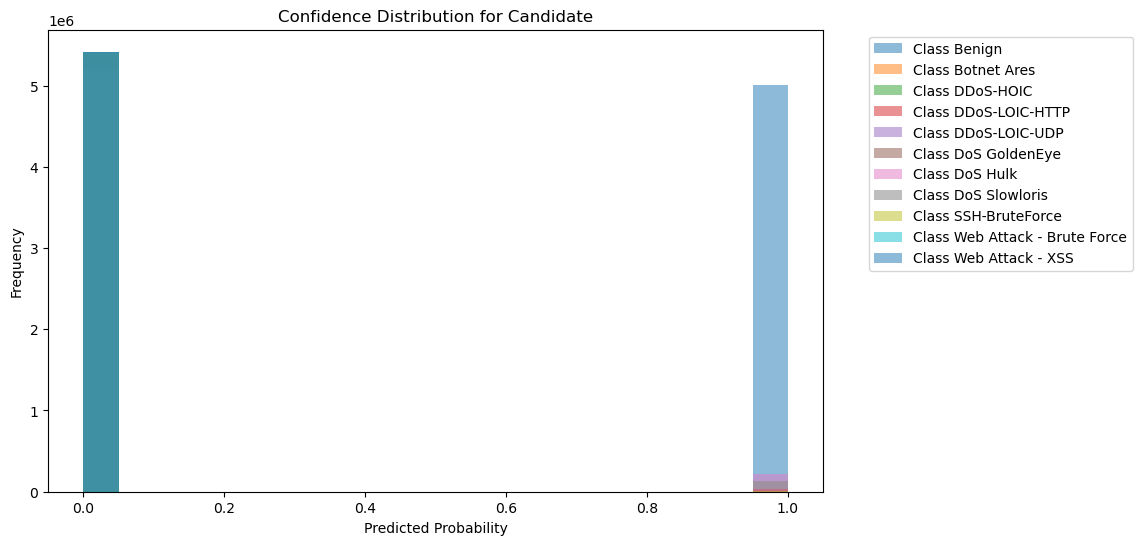

=== Candidate subset-2-autopilot-praxis07PLeah-011-74d08cd5 evaluation completed ===



In [27]:
# Looping through all the top 5 models and visualizing the metrics using sklearn

candidate_name = "subset-2-autopilot-praxis07PLeah-011-74d08cd5"
print(f"\n=== Evaluating candidate: {candidate_name} ===")

# Retrieving the candidate-specific prediction DataFrame
prediction_df = load_myprediction_df

# Loading ground truth
y_true = testing_data["Label"].values

# Parse the "probabilities" column to obtain a numpy array of shape (n_examples, n_classes).
def parse_probability(prob_str):
    # Remove brackets and split by comma.
    return np.array([float(x) for x in prob_str.strip("[]").split(",")])
    
# Apply parsing if the column is of type string.
if prediction_df["probabilities"].dtype == object:
    probs_array = prediction_df["probabilities"].apply(parse_probability)
    probs_matrix = np.vstack(probs_array.values)
else:
    probs_matrix = prediction_df["probabilities"].values


# Parse the model-provided labels from the first row of your inference output.
model_labels = ast.literal_eval(prediction_df["labels"].iloc[0])
classes = model_labels
n_classes = len(classes)

# predicted labels

y_pred = prediction_df["predicted_label"].values


# Binarize the true labels for one-vs-rest evaluation
y_true_bin = label_binarize(y_true, classes=classes)

print(f"Candidate {candidate_name} metrics:")

# Balance Accuracy
print("\nBalanced Accuracy report")
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f"\nModel Balanced Accuracy: {balanced_accuracy:.7f}")

# Accuracy Score
print("\nAccuracy report")
accuracy = accuracy_score(y_true, y_pred)
print(f"\nModel Accuracy: {accuracy:.7f}")

# --- Plot Confusion Matrix ---
print("\n Confusion Metrics")
cm = confusion_matrix(y_true, y_pred, labels=classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Candidate")
plt.show()

# --- Print Average Metrics ---
print("\nClassification Report for Candidate:")
print(classification_report(y_true, y_pred, target_names=[str(cls) for cls in classes]))

# --- ROC curves for each class ---
print("\n ROC Curve")
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs_matrix[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve for Candidate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# --- Precision-Recall curves for each class ---
print("\n Precision-recall Curve")
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], probs_matrix[:, i])
    ap = average_precision_score(y_true_bin[:, i], probs_matrix[:, i])
    plt.plot(recall, precision, lw=2, label=f"Class {cls} (AP = {ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multiclass Precision-Recall Curve for Candidate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# --- Calibration Curves ---
print("\n Calibration Curves")
plt.figure(figsize=(8,6))
for i, cls in enumerate(classes):
    prob_true, prob_pred = calibration_curve(y_true_bin[:, i], probs_matrix[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f"Class {cls}")
plt.plot([0,1], [0,1], "k--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves for Candidate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# --- Lift Curves ---
print("\n Lift Curves")
plt.figure(figsize=(8,6))
for i, cls in enumerate(classes):
    lift_df = compute_lift_curve(y_true_bin[:, i], probs_matrix[:, i], num_bins=10)
    plt.plot(lift_df.index, lift_df["lift"], marker='o', lw=2, label=f"Class {cls}")
plt.xlabel("Bin (sorted by predicted probability)")
plt.ylabel("Lift")
plt.title("Lift Curves for Candidate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# --- Confidence Distribution ---
print("\n Confidence Distribution")
plt.figure(figsize=(10,6))
for i, cls in enumerate(classes):
    plt.hist(probs_matrix[:, i], bins=20, alpha=0.5, label=f"Class {cls}")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Confidence Distribution for Candidate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print(f"=== Candidate {candidate_name} evaluation completed ===\n")


 Confusion Metrics


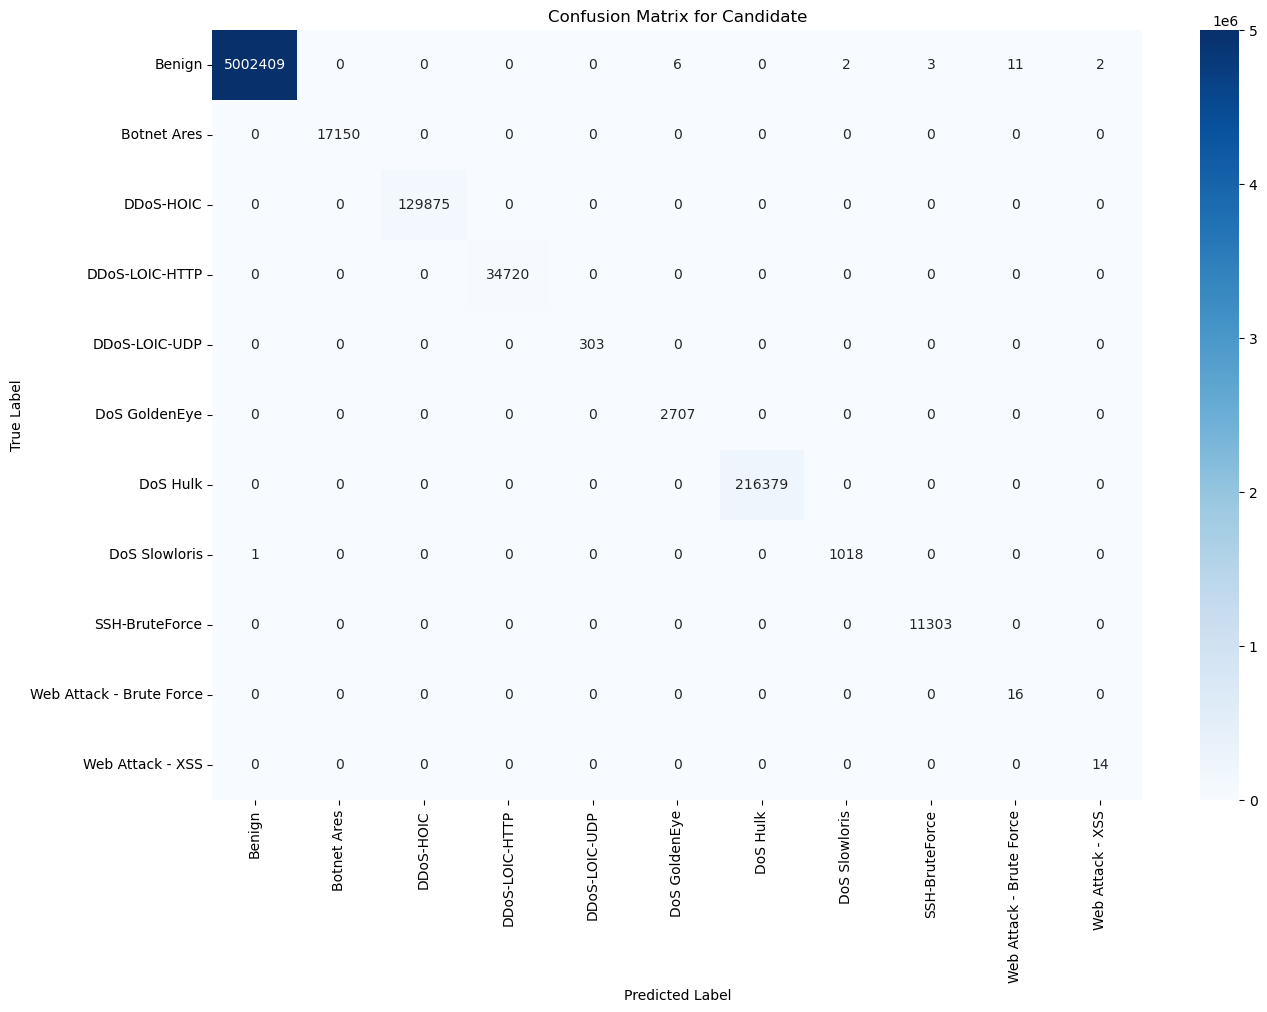

In [28]:
# --- Plot Confusion Matrix ---
print("\n Confusion Metrics")
cm = confusion_matrix(y_true, y_pred, labels=classes)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Candidate")
plt.show()


 Precision-recall Curve


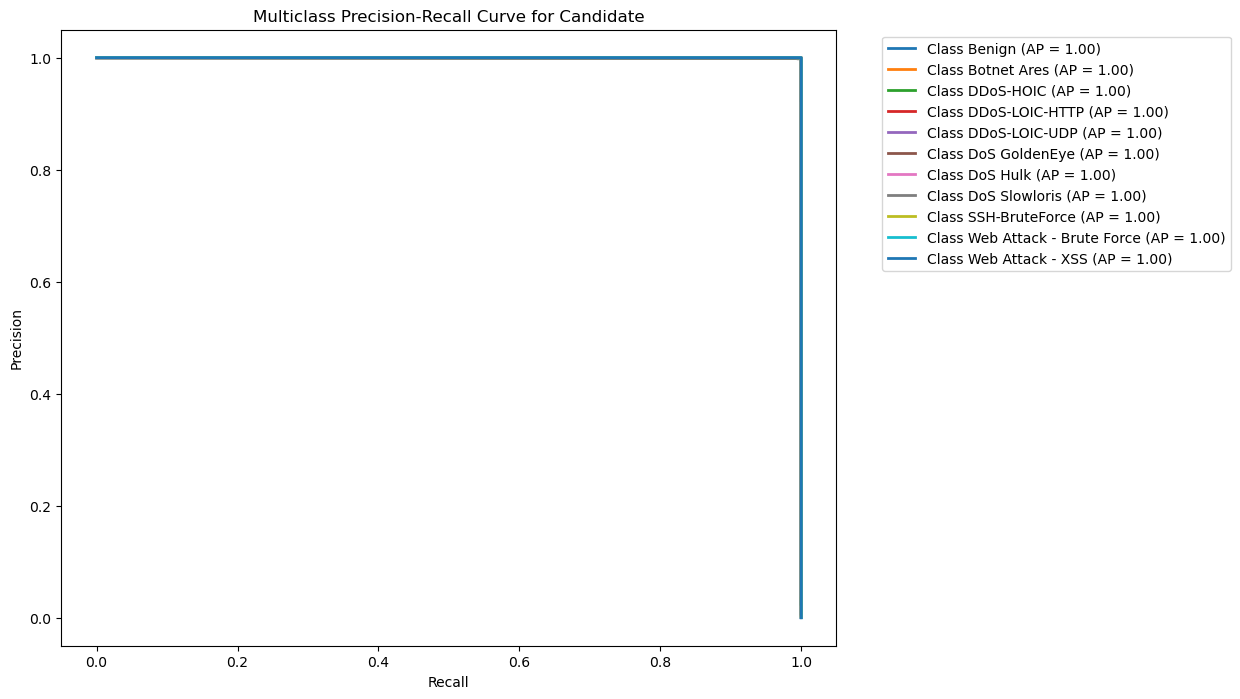

In [29]:
# --- Precision-Recall curves for each class ---
print("\n Precision-recall Curve")
plt.figure(figsize=(10, 8))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], probs_matrix[:, i])
    ap = average_precision_score(y_true_bin[:, i], probs_matrix[:, i])
    plt.plot(recall, precision, lw=2, label=f"Class {cls} (AP = {ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multiclass Precision-Recall Curve for Candidate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


 ROC Curve


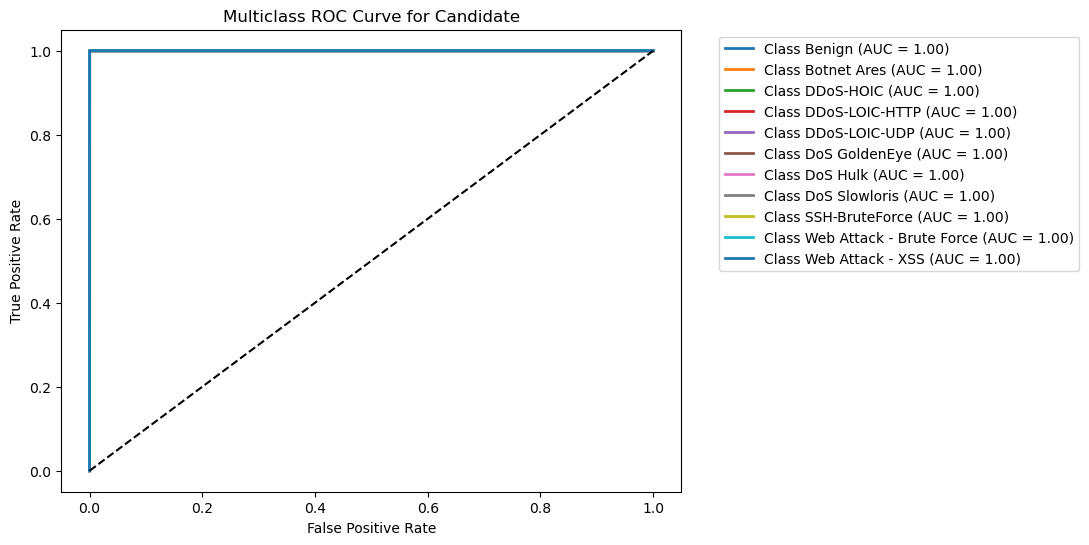

In [30]:
# --- ROC curves for each class ---
print("\n ROC Curve")
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs_matrix[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve for Candidate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [31]:
# --- Print Average Metrics ---
print("\nClassification Report for Candidate:")
print(classification_report(y_true, y_pred, target_names=[str(cls) for cls in classes]))


Classification Report for Candidate:
                          precision    recall  f1-score   support

                  Benign       1.00      1.00      1.00   5002433
             Botnet Ares       1.00      1.00      1.00     17150
               DDoS-HOIC       1.00      1.00      1.00    129875
          DDoS-LOIC-HTTP       1.00      1.00      1.00     34720
           DDoS-LOIC-UDP       1.00      1.00      1.00       303
           DoS GoldenEye       1.00      1.00      1.00      2707
                DoS Hulk       1.00      1.00      1.00    216379
           DoS Slowloris       1.00      1.00      1.00      1019
          SSH-BruteForce       1.00      1.00      1.00     11303
Web Attack - Brute Force       0.59      1.00      0.74        16
        Web Attack - XSS       0.88      1.00      0.93        14

                accuracy                           1.00   5415919
               macro avg       0.95      1.00      0.97   5415919
            weighted avg       1.00 


 Calibration Curves


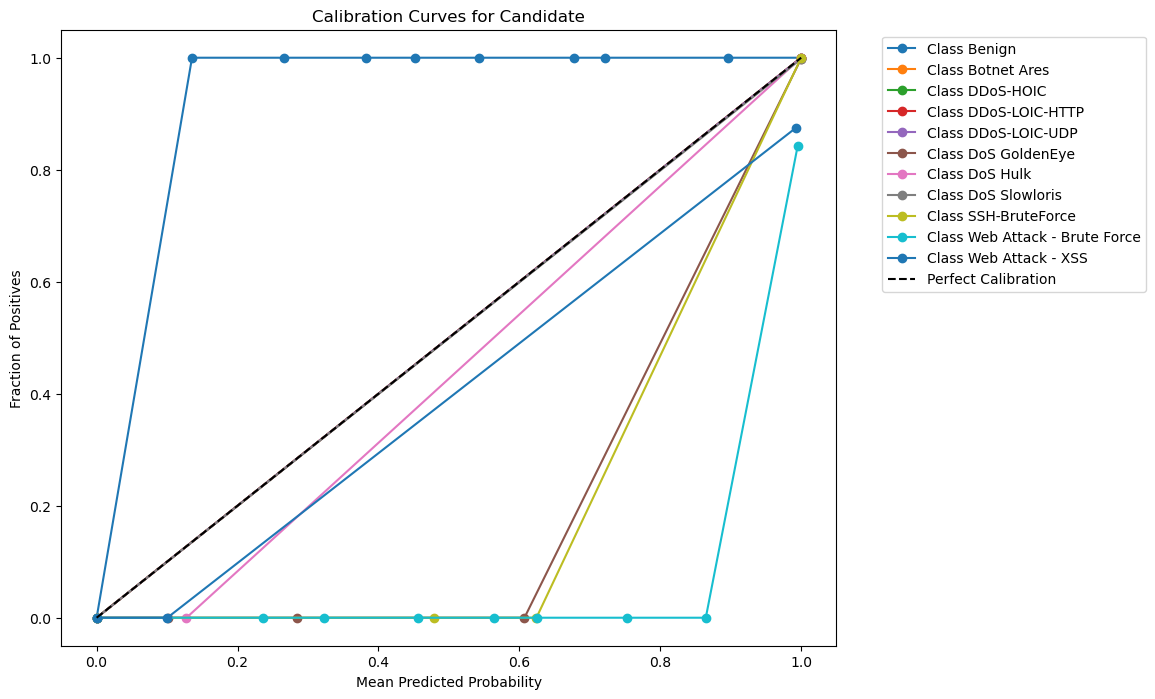

In [32]:
# --- Calibration Curves ---
print("\n Calibration Curves")
plt.figure(figsize=(10,8))
for i, cls in enumerate(classes):
    prob_true, prob_pred = calibration_curve(y_true_bin[:, i], probs_matrix[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f"Class {cls}")
plt.plot([0,1], [0,1], "k--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves for Candidate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


 Lift Curves


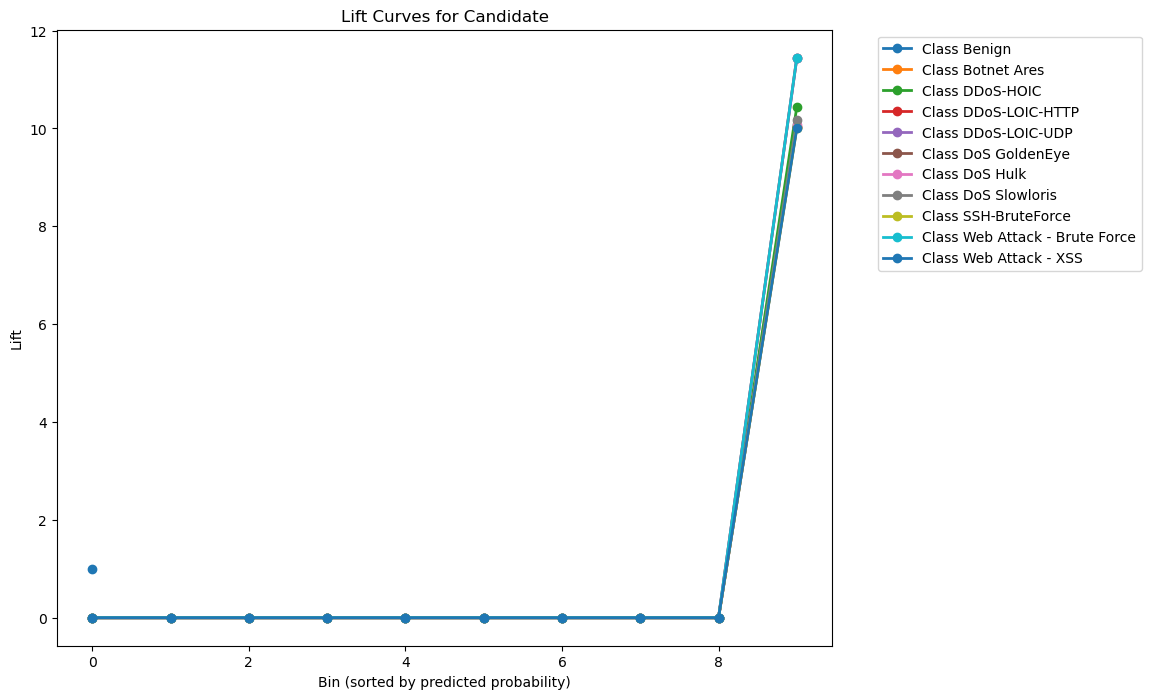

In [33]:
# --- Lift Curves ---
print("\n Lift Curves")
plt.figure(figsize=(10,8))
for i, cls in enumerate(classes):
    lift_df = compute_lift_curve(y_true_bin[:, i], probs_matrix[:, i], num_bins=10)
    plt.plot(lift_df.index, lift_df["lift"], marker='o', lw=2, label=f"Class {cls}")
plt.xlabel("Bin (sorted by predicted probability)")
plt.ylabel("Lift")
plt.title("Lift Curves for Candidate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




 Confidence Distribution


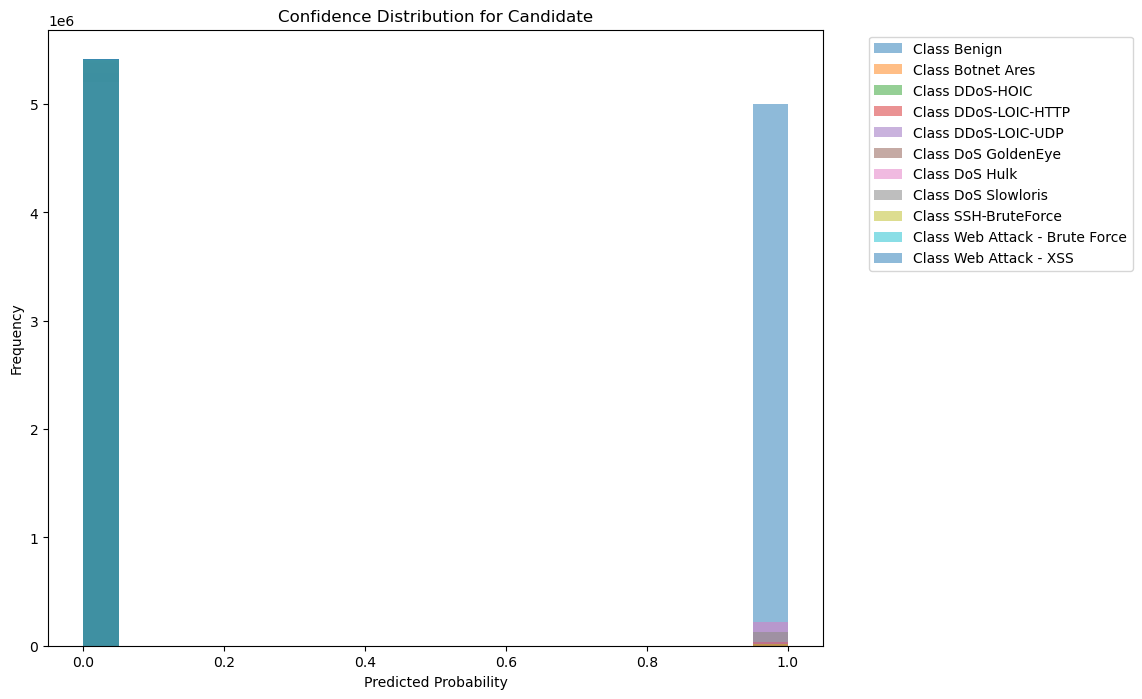

In [34]:
# --- Confidence Distribution ---
print("\n Confidence Distribution")
plt.figure(figsize=(10,8))
for i, cls in enumerate(classes):
    plt.hist(probs_matrix[:, i], bins=20, alpha=0.5, label=f"Class {cls}")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Confidence Distribution for Candidate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Computing Additional Metrics

In [35]:
# Log Loss calculation
logloss = log_loss(y_true, y_pred_probs)
print(f"Log Loss: {logloss:.7f}")

Log Loss: 0.0000409


In [36]:
# Matthews Correlation Coefficient (MCC) calculation
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.7f}")

Matthews Correlation Coefficient (MCC): 0.9999681


In [37]:
# Compute micro-averaged F1 score
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"Micro-averaged F1 score: {f1_micro:.7f}")
print(f"F1 Macro: {f1_macro:.7f}")
print(f"F1 Weighted: {f1_weighted:.7f}")

Micro-averaged F1 score: 0.9999954
F1 Macro: 0.9704369
F1 Weighted: 0.9999957


In [38]:
# Compute Recall metrics
recall_micro = recall_score(y_true, y_pred, average='micro')
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

print(f"Recall Micro: {recall_micro:.7f}")
print(f"Recall Macro: {recall_macro:.7f}")
print(f"Recall Weighted: {recall_weighted:.7f}")

Recall Micro: 0.9999954
Recall Macro: 0.9999103
Recall Weighted: 0.9999954


In [39]:
# Compute AUC Scores
auc_micro = roc_auc_score(y_true, y_pred_probs, average='micro', multi_class='ovr')
auc_macro = roc_auc_score(y_true, y_pred_probs, average='macro', multi_class='ovr')
auc_weighted = roc_auc_score(y_true, y_pred_probs, average='weighted', multi_class='ovr')

print(f"AUC Micro: {auc_micro:.7f}")
print(f"AUC Macro: {auc_macro:.7f}")
print(f"AUC Weighted: {auc_weighted:.7f}")

AUC Micro: 0.9999992
AUC Macro: 0.9999999
AUC Weighted: 0.9999993


In [40]:
# Compute metrics
precision_micro = precision_score(y_true, y_pred, average='micro')
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')

# Output results
print(f"Precision Micro: {precision_micro:.7f}")
print(f"Precision Macro: {precision_macro:.7f}")
print(f"Precision Weighted: {precision_weighted:.7f}")

Precision Micro: 0.9999954
Precision Macro: 0.9511959
Precision Weighted: 0.9999963
